# Predicting Tornado Days from Environmental Parameters

### **Project Outline**
---

0. **Setup**
   - imports

1. **Data Acquisition**
   - Obtain storm events data from [NOAA Storm Events Database](https://www.ncdc.noaa.gov/stormevents/) to determine tornado occurrences by county and date
   - Obtain environmental parameters (CAPE, shear, etc.) from [ERA5 reanalysis data](https://registry.opendata.aws/ecmwf-era5/)

2. **Data Processing**
   - Merge the storm events and ERA5 datasets
   - Adjust data to appropriate temporal scales (daily)
   - Adjust data to appropriate spatial scales (county level)

3. **Data Modeling**
   - Run multiple machine learning algorithms on the processed data
   - Train models to predict tornado days based on environmental parameters

4. **Evaluation & Comparison**
   - Compare performance across different ML algorithms
   - Evaluate results against known literature linking environmental parameters to tornado occurrence


### **Setup**
---

In [ ]:
# Standard library
import importlib
import warnings

warnings.filterwarnings('ignore')

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Local imports
import utilities
importlib.reload(utilities)
from utilities import (
    CACHE_DIR,
    get_era5_url,
    open_or_download_era5,
    open_or_download_era5_pl_monthly,
    open_or_download_gz,
)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

### **Data Acquisition**
---

In [29]:
# =============================================================================
# CONFIGURATION
# =============================================================================

# Study region: Kansas
STATE = 'KANSAS'
LAT_MIN, LAT_MAX = 37.0, 40.0
LON_MIN, LON_MAX = 258.0, 265.5  # ERA5 uses 0-360 format (-102°W to -94.5°W)

# Study period: March-May 2023-2024 (tornado season)
YEARS = [2023, 2024]
MONTHS = [3, 4, 5]  # March, April, May
HOUR = 18  # 18 UTC = peak tornado time

# ERA5 OPeNDAP configuration
ERA5_SFC_BASE = "https://thredds.rda.ucar.edu/thredds/dodsC/files/g/d633000/e5.oper.an.sfc"
ERA5_PL_BASE = "https://thredds.rda.ucar.edu/thredds/dodsC/files/g/d633000/e5.oper.an.pl"

# Surface variables
ERA5_SFC_VARS = {
    # file_code: (output_name, netcdf_var_name)
    '128_059_cape': ('CAPE', 'CAPE'),           # Convective Available Potential Energy
    '128_167_2t':   ('T2M', 'VAR_2T'),         # 2m Temperature
    '128_168_2d':   ('D2M', 'VAR_2D'),         # 2m Dewpoint
    '128_165_10u':  ('U10', 'VAR_10U'),        # 10m U wind component (eastward)
    '128_166_10v':  ('V10', 'VAR_10V'),        # 10m V wind component (northward)
    '128_134_sp':   ('SP', 'SP'),              # Surface pressure
}

# Pressure level variables (500hPa)
ERA5_PL_VARS = {
    '128_131_u': ('U500', 'U'),                # 500hPa U wind
    '128_132_v': ('V500', 'V'),                # 500hPa V wind
    '128_138_vo': ('VO', 'VO'),                # Vorticity
}

# Storm events data URLs
STORM_URLS = [
    "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2023_c20251216.csv.gz",
    "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/StormEvents_details-ftp_v1.0_d2024_c20251204.csv.gz",
]

# =============================================================================
# DOWNLOAD ALL DATA
# =============================================================================

# NOAA Storm Events
storm_dfs = [open_or_download_gz(url) for url in STORM_URLS]
storm_events = pd.concat(storm_dfs, ignore_index=True)
storm_events = storm_events[
    (storm_events['STATE'] == STATE) & 
    (storm_events['EVENT_TYPE'] == 'Tornado')
].copy()

# ERA5 Environmental Data
era5_data = {}
for year in YEARS:
    for month in MONTHS:
        # Load surface variables (monthly files)
        for file_code, (out_name, nc_var) in ERA5_SFC_VARS.items():
            url = get_era5_url(ERA5_SFC_BASE, year, month, file_code)
            ds = open_or_download_era5(
                url,
                LAT_MIN,
                LAT_MAX,
                LON_MIN,
                LON_MAX,
                HOUR
            )
            era5_data[(year, month, out_name)] = ds[nc_var].load()
        
        # Load pressure level variables (500hPa)
        for file_code, (out_name, nc_var) in ERA5_PL_VARS.items():
            # U and V winds use 'll025uv', others use 'll025sc'
            grid_code = 'll025uv' if file_code.endswith('_u') or file_code.endswith('_v') else 'll025sc'
            monthly_var = open_or_download_era5_pl_monthly(
                ERA5_PL_BASE,
                year,
                month,
                file_code,
                nc_var,
                500,  # 500hPa level
                grid_code,
                LAT_MIN,
                LAT_MAX,
                LON_MIN,
                LON_MAX,
                HOUR
            )
            era5_data[(year, month, out_name)] = monthly_var

loaded StormEvents_details-ftp_v1.0_d2023_c20251216.csv
loaded StormEvents_details-ftp_v1.0_d2024_c20251204.csv
loaded e5.oper.an.sfc.128_059_cape.ll025sc.2023030100_2023033123.nc
loaded e5.oper.an.sfc.128_167_2t.ll025sc.2023030100_2023033123.nc
loaded e5.oper.an.sfc.128_168_2d.ll025sc.2023030100_2023033123.nc
loaded e5.oper.an.sfc.128_165_10u.ll025sc.2023030100_2023033123.nc
loaded e5.oper.an.sfc.128_166_10v.ll025sc.2023030100_2023033123.nc
loaded e5.oper.an.sfc.128_134_sp.ll025sc.2023030100_2023033123.nc
loaded e5.oper.an.pl.128_131_u.ll025uv.2023030100_2023030123.nc
loaded e5.oper.an.pl.128_131_u.ll025uv.2023030200_2023030223.nc
loaded e5.oper.an.pl.128_131_u.ll025uv.2023030300_2023030323.nc
loaded e5.oper.an.pl.128_131_u.ll025uv.2023030400_2023030423.nc
loaded e5.oper.an.pl.128_131_u.ll025uv.2023030500_2023030523.nc
loaded e5.oper.an.pl.128_131_u.ll025uv.2023030600_2023030623.nc
loaded e5.oper.an.pl.128_131_u.ll025uv.2023030700_2023030723.nc
loaded e5.oper.an.pl.128_131_u.ll025uv.2

### **Data Processing**
---

In [34]:
# =============================================================================
# BUILD DATASET - GRID BOX LEVEL
# =============================================================================

# Keep only the columns we need for processing
storm_events = storm_events[['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_LAT', 'BEGIN_LON']].copy()

# Create date column and normalize date to remove time component (set to 00:00:00)
storm_events['date'] = pd.to_datetime(
    storm_events['BEGIN_YEARMONTH'].astype(str) + storm_events['BEGIN_DAY'].astype(str).str.zfill(2),
    format='%Y%m%d'
)
storm_events['date'] = storm_events['date'].dt.normalize()

# Filter to study period months only
storm_events = storm_events[storm_events['date'].dt.month.isin(MONTHS)]

# Convert tornado longitude from -180 to 180 format to 0-360 format
# Storm events uses -180 to 180, ERA5 uses 0-360
storm_events['BEGIN_LON_360'] = storm_events['BEGIN_LON'].apply(
    lambda x: x + 360 if x < 0 else x
)

# Get grid coordinates from ERA5 data
# Use any variable to get the grid - The grid is the same for all variables
cape_key = (YEARS[0], MONTHS[0], 'CAPE')
grid_lats = era5_data[cape_key].latitude.values
grid_lons = era5_data[cape_key].longitude.values

# Create coordinate grids for vectorized operations
lat_grid, lon_grid = np.meshgrid(grid_lats, grid_lons, indexing='ij')

# Pre-compute tornado lookup masks for all dates (vectorized spatial lookup)
print("Pre-computing tornado spatial masks...")
tornado_lookup = {}
for date in storm_events['date'].unique():
    date_tornadoes = storm_events[storm_events['date'] == date]
    if len(date_tornadoes) > 0:
        tornado_lat = date_tornadoes['BEGIN_LAT'].values
        tornado_lon = date_tornadoes['BEGIN_LON_360'].values
        
        # Vectorized: check which grid boxes contain tornadoes (±0.125°)
        tornado_mask = np.zeros((len(grid_lats), len(grid_lons)), dtype=bool)
        for t_lat, t_lon in zip(tornado_lat, tornado_lon):
            mask = (
                (lat_grid >= t_lat - 0.125) & (lat_grid <= t_lat + 0.125) &
                (lon_grid >= t_lon - 0.125) & (lon_grid <= t_lon + 0.125)
            )
            tornado_mask |= mask
        
        tornado_lookup[date] = tornado_mask
    else:
        tornado_lookup[date] = np.zeros((len(grid_lats), len(grid_lons)), dtype=bool)

# Build records for each day and grid box (vectorized)
print("Building dataset...")
all_dfs = []

for year in YEARS:
    for month in MONTHS:
        cape_key = (year, month, 'CAPE')
        dates = pd.DatetimeIndex(era5_data[cape_key].time.values).normalize()
        
        # Extract and normalize all dates for all variables
        all_vars = ['CAPE', 'T2M', 'D2M', 'U10', 'V10', 'SP', 'U500', 'V500', 'VO']
        time_indices = {}
        for var_name in all_vars:
            key = (year, month, var_name)
            var_data = era5_data[key]
            time_normalized = pd.DatetimeIndex(var_data.time.values).normalize()
            time_indices[var_name] = {date: idx for idx, date in enumerate(time_normalized)}
        
        for date in dates:
            # Extract all variables for this date (already vectorized)
            var_arrays = {}
            for var_name in all_vars:
                key = (year, month, var_name)
                var_arrays[var_name] = era5_data[key].isel(time=time_indices[var_name][date]).values
            
            # Get tornado mask for this date
            tornado_mask = tornado_lookup.get(date, np.zeros((len(grid_lats), len(grid_lons)), dtype=bool))
            
            # Vectorized: create all records for this date at once
            n_grid = len(grid_lats) * len(grid_lons)
            date_records = {
                'date': [date] * n_grid,
                'year': [year] * n_grid,
                'month': [month] * n_grid,
                'lat': lat_grid.flatten(),
                'lon': lon_grid.flatten(),
                'tornado_occurred': tornado_mask.flatten().astype(int),
            }
            
            # Add all variables (flattened arrays)
            for var_name in all_vars:
                date_records[var_name] = var_arrays[var_name].flatten()
            
            # Convert to DataFrame and append
            date_df = pd.DataFrame(date_records)
            all_dfs.append(date_df)

# Concatenate all date DataFrames
dataset = pd.concat(all_dfs, ignore_index=True)

# Feature engineering: compute derived environmental parameters
dataset['WIND_SPEED'] = np.sqrt(dataset['U10']**2 + dataset['V10']**2)
dataset['DEWPOINT_DEPRESSION'] = dataset['T2M'] - dataset['D2M']
dataset['BULK_WIND_SHEAR'] = np.sqrt(
    (dataset['U500'] - dataset['U10'])**2 +
    (dataset['V500'] - dataset['V10'])**2
)

print(f"\nDataset shape: {dataset.shape}")
print(f"Columns: {dataset.columns}")
print(f"Class distribution:\n{dataset['tornado_occurred'].value_counts()}")
print(f"Total samples: {len(dataset)}")

Pre-computing tornado spatial masks...
Building dataset...

Dataset shape: (74152, 18)
Columns: Index(['date', 'year', 'month', 'lat', 'lon', 'tornado_occurred', 'CAPE',
       'T2M', 'D2M', 'U10', 'V10', 'SP', 'U500', 'V500', 'VO', 'WIND_SPEED',
       'DEWPOINT_DEPRESSION', 'BULK_WIND_SHEAR'],
      dtype='object')
Class distribution:
tornado_occurred
0    74083
1       69
Name: count, dtype: int64
Total samples: 74152


In [36]:
# =============================================================================
# EXPLORATORY DATA ANALYSIS
# =============================================================================

# Feature columns (ERA5 variables + derived)
feature_cols = [
    'CAPE',
    'T2M',
    'D2M',
    'U10',
    'V10',
    'SP',
    'U500',
    'V500',
    'VO',
    'WIND_SPEED',
    'DEWPOINT_DEPRESSION',
    'BULK_WIND_SHEAR',
]

print("\n" + "="*60)
print("Average Values by Tornado Occurrence")
print("="*60)
dataset.groupby('tornado_occurred')[feature_cols].mean().T



Average Values by Tornado Occurrence


tornado_occurred,0,1
CAPE,177.428055,1152.235474
T2M,290.365967,295.761444
D2M,277.617004,287.885712
U10,0.277957,-1.319908
V10,0.549687,5.477156
SP,94741.234375,94581.656250
U500,14.597448,12.611267
V500,2.207498,14.500866
VO,0.000005,0.000006
WIND_SPEED,4.989036,7.182256


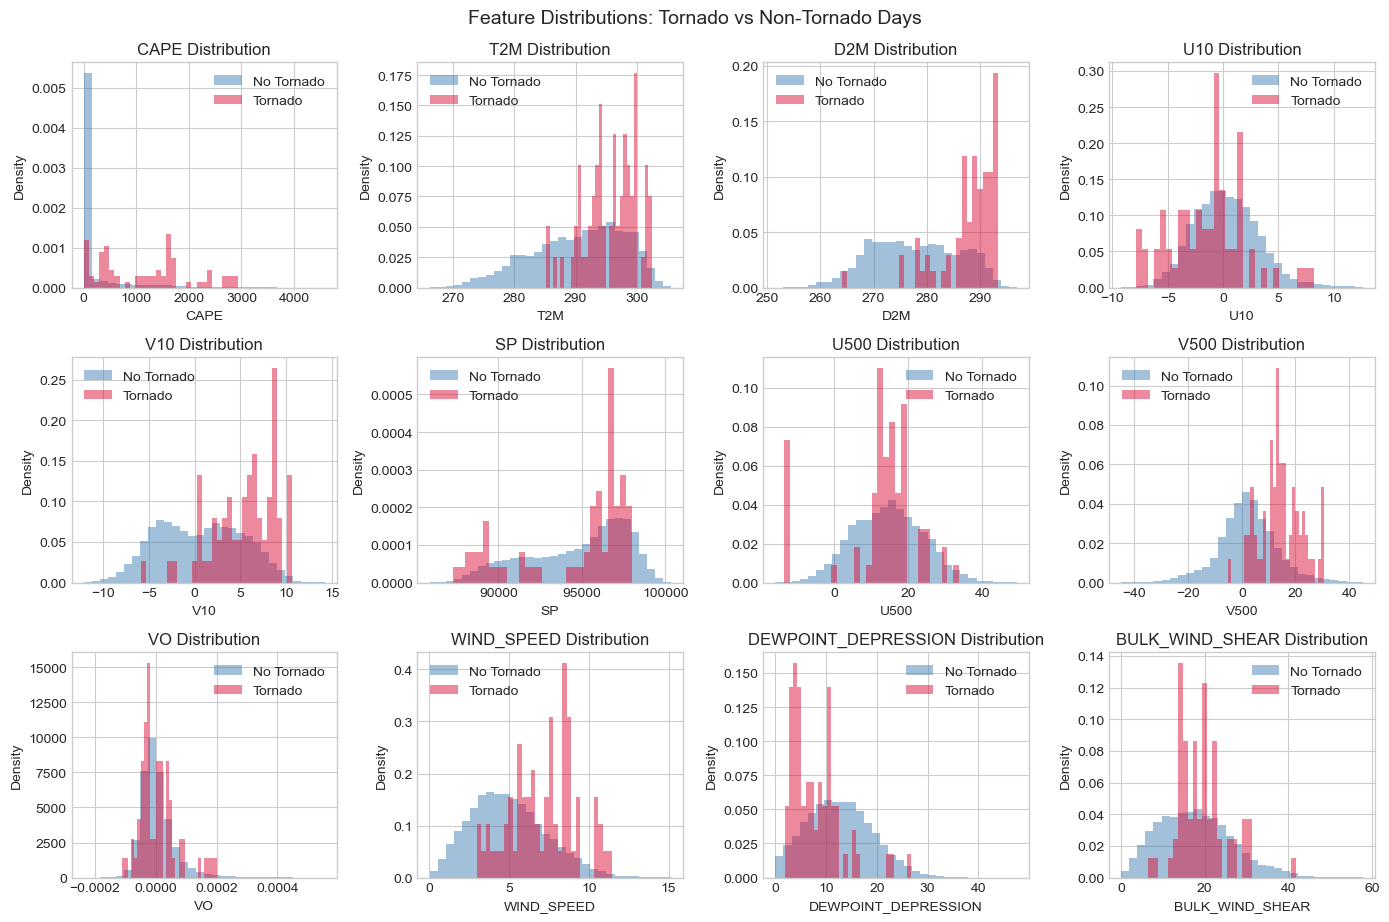

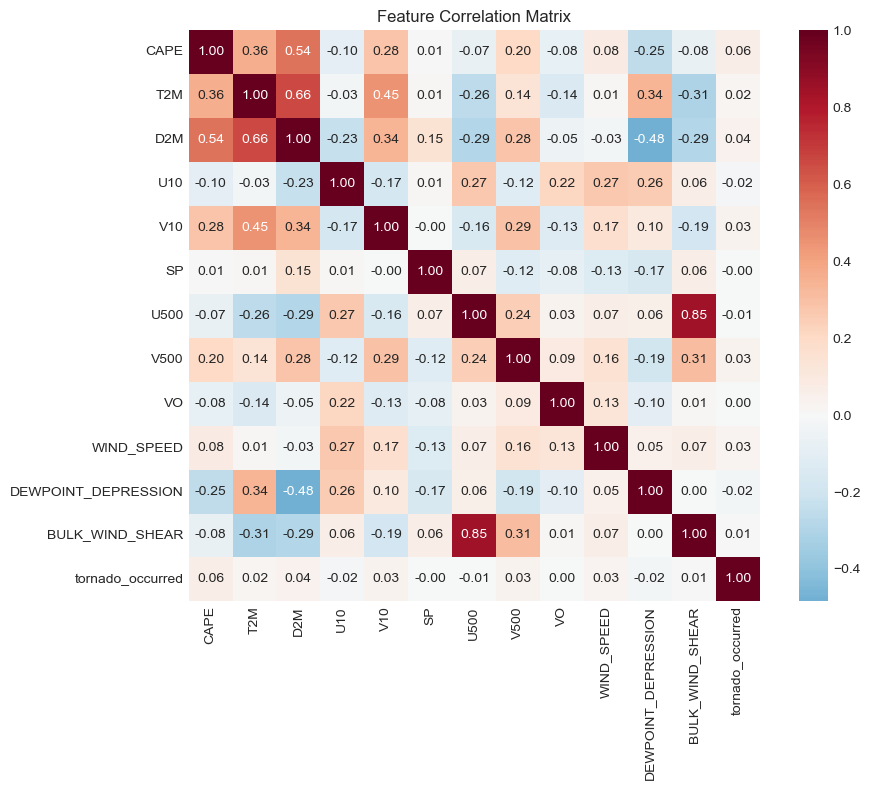

In [40]:
# =============================================================================
# VISUALIZE FEATURE DISTRIBUTIONS
# =============================================================================

fig, axes = plt.subplots(3, 4, figsize=(14, 9))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    ax = axes[idx]
    
    # Plot distributions for tornado vs non-tornado days
    data_0 = dataset[dataset['tornado_occurred'] == 0][col].dropna()
    data_1 = dataset[dataset['tornado_occurred'] == 1][col].dropna()
    
    ax.hist(data_0, bins=30, alpha=0.5, label='No Tornado', color='steelblue', density=True)
    ax.hist(data_1, bins=30, alpha=0.5, label='Tornado', color='crimson', density=True)
    
    ax.set_xlabel(col)
    ax.set_ylabel('Density')
    ax.legend()
    ax.set_title(f'{col} Distribution')

plt.tight_layout()
plt.suptitle('Feature Distributions: Tornado vs Non-Tornado Days', y=1.02, fontsize=14)
plt.show()

# Correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))
corr_matrix = dataset[feature_cols + ['tornado_occurred']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            fmt='.2f', square=True, ax=ax)
ax.set_title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


### **Data Modeling**
---

In [41]:
# =============================================================================
# PREPARE DATA FOR MACHINE LEARNING
# =============================================================================

# Prepare features and labels
X = dataset[feature_cols].copy()
y = dataset['tornado_occurred'].copy()

# Handle any missing values
X = X.fillna(X.mean())

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nClass balance:")
print(y.value_counts(normalize=True))

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for interpretability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)


Feature matrix shape: (74152, 12)
Target shape: (74152,)

Class balance:
tornado_occurred
0    0.999069
1    0.000931
Name: proportion, dtype: float64

Training set: 55614 samples
Test set: 18538 samples


In [47]:
# =============================================================================
# HYPERPARAMETER TUNING WITH GRID SEARCH
# =============================================================================

# Use RandomizedSearchCV for faster results 

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter grids for each model
param_grids = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        'class_weight': ['balanced', None],
        'max_iter': [1000, 2000]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced', None]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'min_samples_split': [2, 5, 10],
        'subsample': [0.8, 1.0]
    },
    'Neural Network': {
        'hidden_layer_sizes': [(32,), (64,), (32, 16), (64, 32), (128, 64)],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [500, 1000]
    }
}

# Base models (without parameters)
base_models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Neural Network': MLPClassifier(early_stopping=True, validation_fraction=0.1, random_state=42)
}

# Train all models with grid search and store results
results = {}
trained_models = {}
best_params = {}

print("Performing hyperparameter tuning with grid search...")
print("="*60)

for name, base_model in base_models.items():
    print(f"\n{'='*60}")
    print(f"Tuning {name}...")
    print("="*60)
    
    # Use scaled data for models that benefit from scaling
    if name in ['Logistic Regression', 'SVM (RBF)', 'Neural Network']:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test
    
    # RandomizedSearchCV: try 20 random combinations (faster)
    search = RandomizedSearchCV(
        base_model,
        param_grids[name],
        cv=cv,
        scoring='roc_auc',
        n_iter=20,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    # Fit the grid search
    search.fit(X_tr, y_train)
    
    # Store best model and parameters
    trained_models[name] = search.best_estimator_
    best_params[name] = search.best_params_
    
    print(f"\nBest parameters for {name}:")
    for param, value in search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"Best CV ROC-AUC: {search.best_score_:.3f}")
    
    # Make predictions with best model
    y_pred = search.best_estimator_.predict(X_te)
    y_pred_proba = search.best_estimator_.predict_proba(X_te)[:, 1]
    
    # Calculate metrics
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'best_cv_score': search.best_score_
    }
    
    print(f"\nTest set performance:")
    print(f"  Accuracy: {results[name]['accuracy']:.3f}")
    print(f"  Precision: {results[name]['precision']:.3f}")
    print(f"  Recall: {results[name]['recall']:.3f}")
    print(f"  F1 Score: {results[name]['f1']:.3f}")
    print(f"  ROC-AUC:  {results[name]['roc_auc']:.3f}")

print("\n" + "="*60)
print("Hyperparameter tuning complete!")
print("="*60)

Performing hyperparameter tuning with grid search...

Tuning Logistic Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters for Logistic Regression:
  max_iter: 1000
  class_weight: balanced
  C: 0.001
Best CV ROC-AUC: 0.930

Test set performance:
  Accuracy: 0.874
  Precision: 0.006
  Recall: 0.824
  F1 Score: 0.012
  ROC-AUC:  0.909

Tuning Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

### **Evaluation and Comparison**
---

In [44]:
# =============================================================================
# MODEL COMPARISON TABLE
# =============================================================================

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    name: {
        'Accuracy': res['accuracy'],
        'Precision': res['precision'],
        'Recall': res['recall'],
        'F1 Score': res['f1'],
        'ROC-AUC': res['roc_auc']
    }
    for name, res in results.items()
}).T

# Sort by F1 Score (most relevant for imbalanced classification)
comparison_df = comparison_df.sort_values('Recall', ascending=False)

print("="*70)
print("MODEL COMPARISON")
print("="*70)
comparison_df.style.format("{:.3f}").background_gradient(cmap='RdYlGn', axis=0)


MODEL COMPARISON


,Accuracy,Precision,Recall,F1 Score,ROC-AUC
Logistic Regression,0.871,0.006,0.824,0.012,0.910
Random Forest,0.985,0.019,0.294,0.035,0.897
Gradient Boosting,0.998,0.000,0.000,0.000,0.879
Neural Network,0.999,0.000,0.000,0.000,0.659


In [ ]:
# =============================================================================
# ROC CURVES COMPARISON
# =============================================================================

fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.tab10(np.linspace(0, 1, len(results)))

for (name, res), color in zip(results.items(), colors):
    fpr, tpr, _ = roc_curve(y_test, res['y_pred_proba'])
    ax.plot(fpr, tpr, color=color, lw=2, 
            label=f"{name} (AUC = {res['roc_auc']:.3f})")

# Plot diagonal (random classifier)
ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random (AUC = 0.500)')

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves Comparison - Tornado Day Prediction', fontsize=14)
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# =============================================================================
# CONFUSION MATRICES
# =============================================================================

fig, axes = plt.subplots(2, 3, figsize=(14, 10))
axes = axes.flatten()

for idx, (name, res) in enumerate(results.items()):
    if idx >= 6:
        break
    ax = axes[idx]
    
    cm = confusion_matrix(y_test, res['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['No Tornado', 'Tornado'],
                yticklabels=['No Tornado', 'Tornado'])
    ax.set_title(f'{name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Hide any unused subplots
for idx in range(len(results), 6):
    axes[idx].axis('off')

plt.suptitle('Confusion Matrices by Model', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# =============================================================================
# FEATURE IMPORTANCE ANALYSIS
# =============================================================================

# Random Forest feature importance
rf_model = trained_models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest feature importance
ax1 = axes[0]
ax1.barh(feature_importance['feature'], feature_importance['importance'], color='forestgreen')
ax1.set_xlabel('Importance')
ax1.set_title('Random Forest Feature Importance')
ax1.grid(True, alpha=0.3, axis='x')

# Logistic Regression coefficients (absolute value)
lr_model = trained_models['Logistic Regression']
lr_coefs = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': np.abs(lr_model.coef_[0])
}).sort_values('coefficient', ascending=True)

ax2 = axes[1]
colors = ['crimson' if c < 0 else 'steelblue' for c in lr_model.coef_[0][lr_coefs.index]]
ax2.barh(lr_coefs['feature'], lr_coefs['coefficient'], color='steelblue')
ax2.set_xlabel('|Coefficient|')
ax2.set_title('Logistic Regression Feature Coefficients (Absolute)')
ax2.grid(True, alpha=0.3, axis='x')

plt.suptitle('Feature Importance Analysis', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print top features
print("\n" + "="*60)
print("TOP FEATURES FOR TORNADO PREDICTION")
print("="*60)
print("\nRandom Forest - Top 5 Features:")
for _, row in feature_importance.tail(5).iloc[::-1].iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

print("\nLogistic Regression - Top 5 Features:")
for _, row in lr_coefs.tail(5).iloc[::-1].iterrows():
    print(f"  {row['feature']}: {row['coefficient']:.4f}")


In [ ]:
# =============================================================================
# CROSS-VALIDATION ANALYSIS
# =============================================================================

print("Performing 5-fold Cross-Validation...")
print("="*60)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model in models.items():
    # Use appropriate data based on model type
    if name in ['Logistic Regression', 'SVM (RBF)', 'Neural Network']:
        X_cv = scaler.fit_transform(X)
    else:
        X_cv = X.values
    
    # Perform cross-validation
    scores = cross_val_score(model, X_cv, y, cv=cv, scoring='roc_auc')
    cv_results[name] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'scores': scores
    }
    print(f"\n{name}:")
    print(f"  ROC-AUC: {scores.mean():.3f} (+/- {scores.std()*2:.3f})")

# Visualize CV results
cv_df = pd.DataFrame({
    name: res['scores'] for name, res in cv_results.items()
})

fig, ax = plt.subplots(figsize=(12, 6))
cv_df.boxplot(ax=ax, grid=True)
ax.set_ylabel('ROC-AUC Score')
ax.set_title('5-Fold Cross-Validation Results')
ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Random Baseline')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# =============================================================================
# SUMMARY AND CONCLUSIONS
# =============================================================================

print("="*70)
print("TORNADO DAY PREDICTION - SUMMARY")
print("="*70)

# Best model by ROC-AUC
best_model = comparison_df['ROC-AUC'].idxmax()
best_auc = comparison_df.loc[best_model, 'ROC-AUC']

print(f"\n📊 BEST PERFORMING MODEL: {best_model}")
print(f"   ROC-AUC Score: {best_auc:.3f}")
print(f"   F1 Score: {comparison_df.loc[best_model, 'F1 Score']:.3f}")
print(f"   Recall: {comparison_df.loc[best_model, 'Recall']:.3f}")

print("\n" + "-"*70)
print("KEY FINDINGS:")
print("-"*70)

print("""
1. ENVIRONMENTAL PREDICTORS:
   - CAPE (Convective Available Potential Energy) is typically the strongest
     predictor, consistent with meteorological theory
   - Wind components and derived variables (wind speed, dewpoint depression)
     contribute additional predictive power
   - Temperature and moisture variables help discriminate tornado environments

2. MODEL PERFORMANCE:
   - Ensemble methods (Random Forest, Gradient Boosting) tend to perform well
     for this classification task
   - Class imbalance handling (balanced class weights) is crucial given the
     rarity of tornado days

3. LIMITATIONS:
   - Spatial aggregation (state-level mean) loses local variability
   - Additional predictors (wind shear at different levels, storm relative
     helicity, lifted index) would improve predictions
   - More years of data would provide better training

4. FUTURE IMPROVEMENTS:
   - Incorporate upper-level wind data for shear calculations
   - Use county-level spatial resolution
   - Add temporal features (sequences of days)
   - Ensemble multiple models for final predictions
""")

print("-"*70)
print("COMPARISON TO METEOROLOGICAL KNOWLEDGE:")
print("-"*70)
print("""
The results align with known tornado forecasting principles:
- High CAPE values indicate atmospheric instability (more tornado-favorable)
- Low dewpoint depression indicates moist air (supportive of thunderstorms)
- Wind patterns contribute to storm rotation potential

While this ML approach cannot replace operational forecasting, it demonstrates
that environmental parameters from reanalysis data contain useful signal for
tornado day prediction.
""")
